In [5]:
#%% Loading usefull packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


In [ ]:
# I couldn't figure out how to get the soil heat flux data that we measoured, so for now I'm using the MAQ observations, available at https://maq-observations.nl/veenkampen/


Loading data
              TIMESTAMP   VWC2  Temp2   VWC5  Temp5   VWC8  Temp8
2     17 Jun 2025 10:40  0.604   26.8  0.722   24.5  0.779   20.8
3     17 Jun 2025 10:41  0.605   26.8  0.722   24.5  0.779   20.9
4     17 Jun 2025 10:42  0.605   26.9  0.722   24.6  0.780   20.9
5     17 Jun 2025 10:43  0.604   26.9  0.722   24.6  0.777   20.9
6     17 Jun 2025 10:44  0.605   26.9  0.722   24.6  0.779   20.9
...                 ...    ...    ...    ...    ...    ...    ...
1602  18 Jun 2025 13:20  0.584   29.9  0.717   28.2  0.779   24.3
1603  18 Jun 2025 13:21  0.583   30.0  0.717   28.2  0.780   24.3
1604  18 Jun 2025 13:22  0.583   30.0  0.717   28.2  0.778   24.3
1605  18 Jun 2025 13:23  0.583   30.0  0.717   28.2  0.778   24.3
1606  18 Jun 2025 13:24  0.584   30.0  0.717   28.2  0.780   24.3

[1605 rows x 7 columns]
Time starts at :2025-06-17 10:40:00


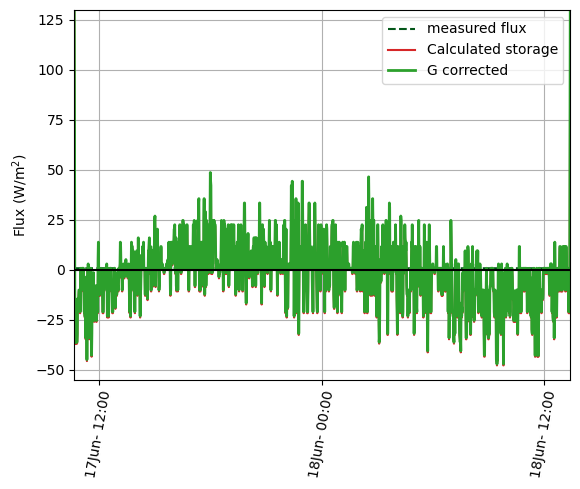

In [25]:
# Python script for correcting soil heat flux using temperature above the heat flux plate.
# Jonathan Eyken, 26-06-2025

# %% SETTINGS: EDIT THIS CODE BLOCK BELOW
#################################################
path = "C:/Users/48512/Desktop/Climate Studies/Period 5 and 6/Field Training Soil-Vegetation-Atmosphere Interactions/VK/" # Set the path to the data directory
file = "soil_data.txt" # File name of data in comma delimited csv format
zG1  = 2 # m Depth of first heat flux plate (SHFP1 in data file)
zG2  = 5 # m Depth of second heat flux plate (SHFP2 in data file)
dt   = 60 # time interval in seconds (30 minutes)

Cs = 1882042 # heat capacity of the soil in J/m3/K for VK (From Anne)

#Select two temperature sensors at different depths:
nameT1   = "VWC2"
nameT2   = "VWC5"
zT1  = 2 #m Depth of sensor 1 (shallower)
zT2  = 5 #m Depth of sensor 2 (deeper)

savecsv    = True
outputname = "G_corrected_swamp.csv"

smoothT = True # Option for smoothing temperature before gradient calculation (less spikes)
#################################################
# Editing below here is not necessary (hopefully)

def rollingavg(array,window):
    array_smooth = []
    array_smooth[:] = array
    for i in range(len(array)-window):
        array_smooth[i+int(np.floor(window/2))] = np.mean(array[i:(i+window)])
    return array_smooth

#%% Loading data
print("Loading data")
data = pd.read_csv(path+file,sep="\t").drop([0,1])
print(data)
time = pd.to_datetime(data["TIMESTAMP"])
print("Time starts at :"+str(np.min(time)))
# %% Reading out soil heat flux
G1 = data["VWC2"].astype(float).values # G1 = 8 cm
G2 = data["VWC5"].astype(float).values # G2 = 2 cm (Probably?)
G  = (G1+G2)/2

# %% Temperature and its tendency.
T1 = data[nameT1].astype(float).values
T2 = data[nameT2].astype(float).values 

# Fill nan values linearly  # FOR A SINGLE NAN VALUE OTHERWISE USE LOOP!
n = 0
while (np.count_nonzero(np.isnan(G1)) > 0):
    i = np.argmax(np.isnan(G1))
    G1[i] = (G1[i-1] + G1[i+1]) / 2
    i = np.argmax(np.isnan(G2))
    G2[i] = (G2[i-1] + G2[i+1]) / 2
    i = np.argmax(np.isnan(T1))
    T1[i] = (T1[i-1] + T1[i+1]) / 2
    i = np.argmax(np.isnan(T2))
    T2[i] = (T2[i-1] + T2[i+1]) / 2
    print("Filled a single NAN value")
    n += 1
    if (n>20):
        print("ERROR: There are too many or consecutive nan values")
        break


# Smooth daT1 for less spiky gradients
if smoothT:
    T1 = rollingavg(T1,window=6)
    T2 = rollingavg(T2,window=6)

# %% Calculate Temperature tendencies using centered method 
# (and forward/backward for first and last values)


# T1 at level 1
dt_T1 = np.zeros([len(T1)])
for i in range(len(dt_T1)-2):
    dt_T1[i+1] = (T1[i+2] - T1[i])/2/dt
dt_T1[0] = (T1[1]-T1[0])/dt
dt_T1[-1] = (T1[-1] - T1[-2])/dt

# T2 at level 2
dt_T2 = np.zeros([len(T2)])
for i in range(len(dt_T2)-2):
    dt_T2[i+1] = (T2[i+2] - T2[i])/2/dt
dt_T2[0] = (T2[1]-T2[0])/dt
dt_T2[-1] = (T2[-1] - T2[-2])/dt


# %% The flux correction:
z_plate = zG1 # m (Also volume of soil per m2)
z_T     = z_plate/2 # Halfway the flux plate

# Linearly interpolate storage to depth halfway the flux plate
slope   = ((dt_T1 - dt_T2) / (zT2 - zT1))
dt_T    = dt_T2 + ((zT2 - z_T) * slope)
storage1 = z_plate*Cs*dt_T
G1_surf = G1 + storage1

z_plate = zG2 # m (Also volume of soil per m2)
z_T     = z_plate/2 # Halfway the flux plate

# Linearly interpolate storage to depth halfway the flux plate
slope   = ((dt_T1 - dt_T2) / (zT2 - zT1))
dt_T    = dt_T2 + ((zT2 - z_T) * slope)
storage2 = z_plate*Cs*dt_T
G2_surf = G2 + storage2


# %% Plotting the result
fig,ax = plt.subplots()
ax.plot(time,G2,label = "measured flux", color="#04571a",ls="--")
ax.plot(time,storage2, label = "Calculated storage",color="tab:red")
ax.plot(time,G2_surf, label = "G corrected",color="tab:green",lw=2)
#ax.hlines(0,xmin=np.datetime64("2025-06-12T06:00:00"),xmax=np.datetime64("2025-06-19T01:00:00"),color="k")#np.min(time),xmax=np.max(time))
ax.hlines(0,xmin=np.min(time),xmax=np.max(time),color="k")#np.min(time),xmax=np.max(time))
ax.set_xlim(xmin=np.min(time),xmax=np.max(time))
ax.set_ylim(-55,130)
ax.grid()
ax.set_ylabel(r"Flux (W/m$^2$)")
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0,12]))     # Manual formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%dJun- %H:%M')) # to get a tick every 12 hours
ax.tick_params(axis="x",labelrotation=80)
ax.legend()
plt.savefig(path+"../soilheatflux.png")
plt.show()


# Writing results to CSV file

if savecsv:
    f = open(path+"../"+outputname, "w").close() # Clear file contents
    with open(path+"../"+outputname, "a") as text_file:
        text_file.write("TIMESTAMP,G1(W/m2),G2(W/m2)\n")
        for i in range(len(time)):
            text_file.write(str(time.values[i])+","+str(G1_surf[i])+","+str(G2_surf[i])+"\n")

# %% Example on how to read out the data in python (or use excel)
# data_time = np.loadtxt(path+"../"+outputname,delimiter=",",dtype=str,usecols=0,skiprows=1)
# time      = np.array(data_time,dtype=np.datetime64)
# G1        = np.loadtxt(path+"../"+outputname,delimiter=",",usecols=[1],skiprows=1)
# G2        = np.loadtxt(path+"../"+outputname,delimiter=",",usecols=[2],skiprows=1)

In [27]:
print(text_file)

<_io.TextIOWrapper name='C:/Users/48512/Desktop/Climate Studies/Period 5 and 6/Field Training Soil-Vegetation-Atmosphere Interactions/VK/../G_corrected_swamp.csv' mode='a' encoding='cp1250'>
